In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:60% !important; }</style>"))

# !!! Change the Filename accordingly !!!

In [2]:
figure_name = 'figures/fig_8_real_world_input_'

In [40]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
from scipy.ndimage.filters import convolve1d
import soundfile as sf
from mpl_toolkits.mplot3d import Axes3D
from skimage import measure
import scipy.constants
from gammatone import gtgram
from gammatone.plot import render_audio_from_file

import matplotlib.pyplot
import matplotlib.ticker

plt.style.use('seaborn-whitegrid')

mpl.rcParams['grid.linestyle'] = ':'   

mpl.rcParams['figure.figsize'] = [20.0, 10.0]
mpl.rcParams['figure.dpi'] = 100
mpl.rcParams['savefig.dpi'] = 400


drawing_size = 25


mpl.rcParams['font.size'] = drawing_size
mpl.rcParams['font.style'] = 'oblique'
mpl.rcParams['font.weight']= 'heavy'



mpl.rcParams['figure.titlesize'] = int(drawing_size*1.3)
mpl.rcParams['figure.titleweight'] = 'heavy'

mpl.rcParams['lines.linewidth'] = int(drawing_size/5)

mpl.rcParams['axes.labelsize'] = drawing_size
mpl.rcParams['axes.labelweight'] = 'heavy'
mpl.rcParams['axes.titlesize'] = int(drawing_size*1.3)
mpl.rcParams['axes.titleweight'] = 'heavy'


mpl.rcParams['legend.fancybox'] = True
mpl.rcParams['legend.fontsize'] = int(drawing_size*0.9)
mpl.rcParams['legend.frameon'] = True
mpl.rcParams['legend.framealpha'] = 0.5
mpl.rcParams['legend.facecolor'] = 'inherit'
mpl.rcParams['legend.edgecolor'] = '0.8'

# print(mpl.rcParams.keys())


In [20]:


   
############################################################
#                  Simulation parameter                    #
############################################################

# Define initial condition (not necessary?)
#x0 = 0

# Time step
dt = 0.001 # -> 10us

# Solve differential equation from time 0 to time T
T = 4.0 # -> 40ms 

# Descretize time into equal steps
t = np . linspace (0 , T , int ( T / dt )+1)


############################################################
#                Network Inputs/Outputs                    #
############################################################

# define the inputs
# assuming we have 16 frquency bands
freq_bands = 24

############################################################
#                 BPC neuron parameter                     #
#  parameters for r_bpc neuron of LSO, all marked by a _r  #
############################################################
# tau defines how fast the membrane potential builds up
tau_r = 1/40.0
# alpha defines the decay rate of the membrane potential but also the value to which it saturates (implicitly)
alpha_r = 1.0
# beta defines the upper limit of the membrane potential
beta_r = 1.0
# gamma defines the subtractive influence of the inhibitory input
gamma_r = 2.0
# kappa defines the divisive influence of the inhibitory input
kappa_r = 3.0

############################################################
#                 PC neuron parameter                      #
#  parameters for q_pc neuron of MNTB, all marked by a _q  #
############################################################
tau_q = 1/40.0
alpha_q = 2.0 
beta_q = 1.0
gamma_q = 0.0
kappa_q = 0.0

############################################################
#                 GABA neuron parameter                    #
#  parameters for p_gaba inhibitory neuron of LSO, all marked by a _p #
############################################################
tau_p = 25
alpha_p = 10.0
beta_p = 10.0

############################################################
#               Gammatone Filter Parameters                #
############################################################
t_window = 0.0008 # each band then have their energy integrated over windows of window_time seconds,
t_hop = t_window/2 # advancing by hop_time secs for successive columns. 
channels = 24 # number of frequency bands
fmin = 20 # lowest frequency


In [21]:
############################################################
#                       Functions                          #
############################################################

def mesh_plot(data,ax):
    # fig is the figure handler
    # data is a 2d array
    # returns the axis of the figure

    # import necessary modules
    from mpl_toolkits.mplot3d import Axes3D
    from matplotlib import cm
    import matplotlib.pyplot as plt
    # define x and y axis
    x = np.linspace(np.min(data[0, :]), np.max(data[0, :]), data.shape[0])
    y = np.linspace(np.min(data[1, :]), np.max(data[1, :]), data.shape[1])
    # x = np.linspace(0, 1, data.shape[0])
    # y = np.linspace(0, 1, data.shape[1])
    x, y = np.meshgrid(x, y)

    # plot data with nice colors
    ax1.plot_surface(
        x,
        y,
        data.T,
        rstride=1,
        cstride=1,
        cmap=cm.viridis,
        shade=True,
        linewidth=20)

    return ax




#define a gauss function
def gauss(x,mean,sigma):
    if sigma == 0.0:
        return np.zeros(x.shape)
    else: 
        return np.exp(-(x-mean)**2 /( 2 * sigma**2 ))


# Defines the output transfer function of r_bpc
def g_r_out(r_bpc,a =20,b=0.25):
    return 1 / (1 + np.exp(-(r_bpc-b)*a) )

# Defines the output transfer function of q_pc
def g_q_out(q_pc):
    return np.maximum(q_pc,0)



# Defines the ODE for the r_bpc neuron
def ode_r_bpc(r_bpc,s_sbc,ee_kernel,q_pc,ei_kernel,gaba_exc=0,gaba_inh=0):
    # get the globally defined parameters
    global tau_r ,alpha_r, beta_r, gamma_r, kappa_r

    # do a subtractive inhibition, this is done by subtracting the g_r_out values from the kernel weights
    # calculate excitatory input, which comes from the SBC cells folded by the E-E kernel

    ee_kernel  = ee_kernel*(1-gaba_exc)
    excitatory_in = np.sum(np.multiply(s_sbc,ee_kernel)) #*  1/(np.exp(gaba_exc))
    # calculate inhibitor input, which comes from the q_pc folded by the I-E kernel
    ei_kernel  = ei_kernel*(1-gaba_inh)
    inhibitory_in = np.sum( np.multiply(g_q_out(q_pc),ei_kernel)) #* 1/(np.exp(gaba_inh))
    # calculate the change of r_bpc
    d_r_bpc = -alpha_r * r_bpc + (beta_r-r_bpc) * excitatory_in - ((gamma_r) + kappa_r * r_bpc) * inhibitory_in
    
        
    return d_r_bpc / tau_r


# Defines the ODE for the q_pc neuron
def ode_q_pc(q_pc, s_gbc,ie_kernel,q_pc_all,ii_kernel):
    # get the globally defined parameters
    global tau_q,alpha_q,beta_q,gamma_q,kappa_q

    # calculate excitatory input, which comes from the GBC cells folded by the I-E kernel
    excitatory_in = np.sum(np.multiply(s_gbc,ie_kernel))
    # calculate inhibitor input, which comes from the q_pc folded by the I-I kernel (self-inhibition)
    inhibitory_in = np.sum( np.multiply(g_q_out(q_pc_all),ii_kernel))
    
    d_q_pc = -alpha_q * q_pc + beta_q * excitatory_in - (gamma_q + kappa_q * q_pc) * inhibitory_in 
    
    return d_q_pc /tau_q

# Defines the ODE for the p_gaba neuron which defines the strength of the modulation (inhibition) of the inputs of the r neuron
def ode_p_pc(p_gaba, r_gbc):
    # get the globally defined parameters
    global tau_p,alpha_p,beta_p

    d_p_pc =   -alpha_p*p_gaba +(beta_p - p_gaba)*g_r_out(r_gbc)  
    return  d_p_pc  / tau_p



In [23]:


class ERBFormatter(matplotlib.ticker.EngFormatter):
    """
    Axis formatter for gammatone filterbank analysis. This formatter calculates
    the ERB spaced frequencies used for analysis, and renders them similarly to
    the engineering axis formatter.

    The scale is changed so that `[0, 1]` corresponds to ERB spaced frequencies
    from ``high_freq`` to ``low_freq`` (note the reversal). It should be used
    with ``imshow`` where the ``extent`` argument is ``[a, b, 1, 0]`` (again,
    note the inversion).
    """

    def __init__(self, low_freq, high_freq, *args, **kwargs):
        """
        Creates a new :class ERBFormatter: for use with ``matplotlib`` plots.
        Note that this class does not supply the ``units`` or ``places``
        arguments; typically these would be ``'Hz'`` and ``0``.

        :param low_freq: the low end of the gammatone filterbank frequency range
        :param high_freq: the high end of the gammatone filterbank frequency
          range
        """
        self.low_freq = low_freq
        self.high_freq = high_freq
        super().__init__(*args, **kwargs)

    def _erb_axis_scale(self, fraction):
        return erb_point(self.low_freq, self.high_freq, fraction)

    def __call__(self, val, pos=None):
        newval = self._erb_axis_scale(val)
        return super().__call__(newval, pos)

In [66]:
test_ild = -90
test_recording = 'sinus_2500Hz_normalEars'
# test_recording = 'whiteNoise_1_20000Hz_normalEars'

############################################################
#                  Input Data Readout                      #
############################################################
stri = '/home/oesst/ownCloud/PhD/binaural head/recordings/full_head/'+test_recording+'/azimuth_'+str(test_ild)+'/'+test_recording+'_azi_'+str(test_ild)+'_ele_0_right.wav'
data_r = sf.read(stri)[0]
stri = '/home/oesst/ownCloud/PhD/binaural head/recordings/full_head/'+test_recording+'/azimuth_'+str(test_ild)+'/'+test_recording+'_azi_'+str(test_ild)+'_ele_0_left.wav'
data_l = sf.read(stri)


# get the rate
fs = data_l[1]
data_l = data_l[0]


duration = len(data_l) / fs
psd_l = gtgram.gtgram(data_l, fs, t_window, t_hop, channels, fmin)
psd_l = np.flipud(psd_l).T
# psd_l = np.flipud(20 * np.log10(psd_l)).T

psd_r = gtgram.gtgram(data_r, fs, t_window, t_hop, channels, fmin)
psd_r = np.flipud(psd_r).T
# psd_r = np.flipud(20 * np.log10(psd_r)).T

# # print(psd_l.shape[0]/10000)

# Time step
dt = 0.0001 # -> 100us

T = psd_l.shape[0]/10000

# Solve differential equation from time 0 to time T
# Descretize time into equal steps
t = np . linspace (0 , T , int ( T / dt ))

############################################################
#                Network Inputs/Outputs                    #
############################################################

# define the inputs
# assuming we have 16 frquency bands
s_gbc_all= psd_l
s_sbc_all = psd_r

s_gbc_all -= np.min(s_gbc_all)
s_sbc_all -= np.min(s_sbc_all)


maxi = np.max([np.abs(np.max(s_gbc_all)),np.abs(np.max(s_sbc_all))])
print(maxi)
# we need to normlize the input by a constant value over all recording (otherwise we create a level invariance
# between recording that would lead to wrong levels)
s_gbc_all /= maxi
s_sbc_all /= maxi

# plt.pcolor(s_sbc_all.T,cmap='viridis')
# plt.show()



0.0921850712055286


(4095, 24)


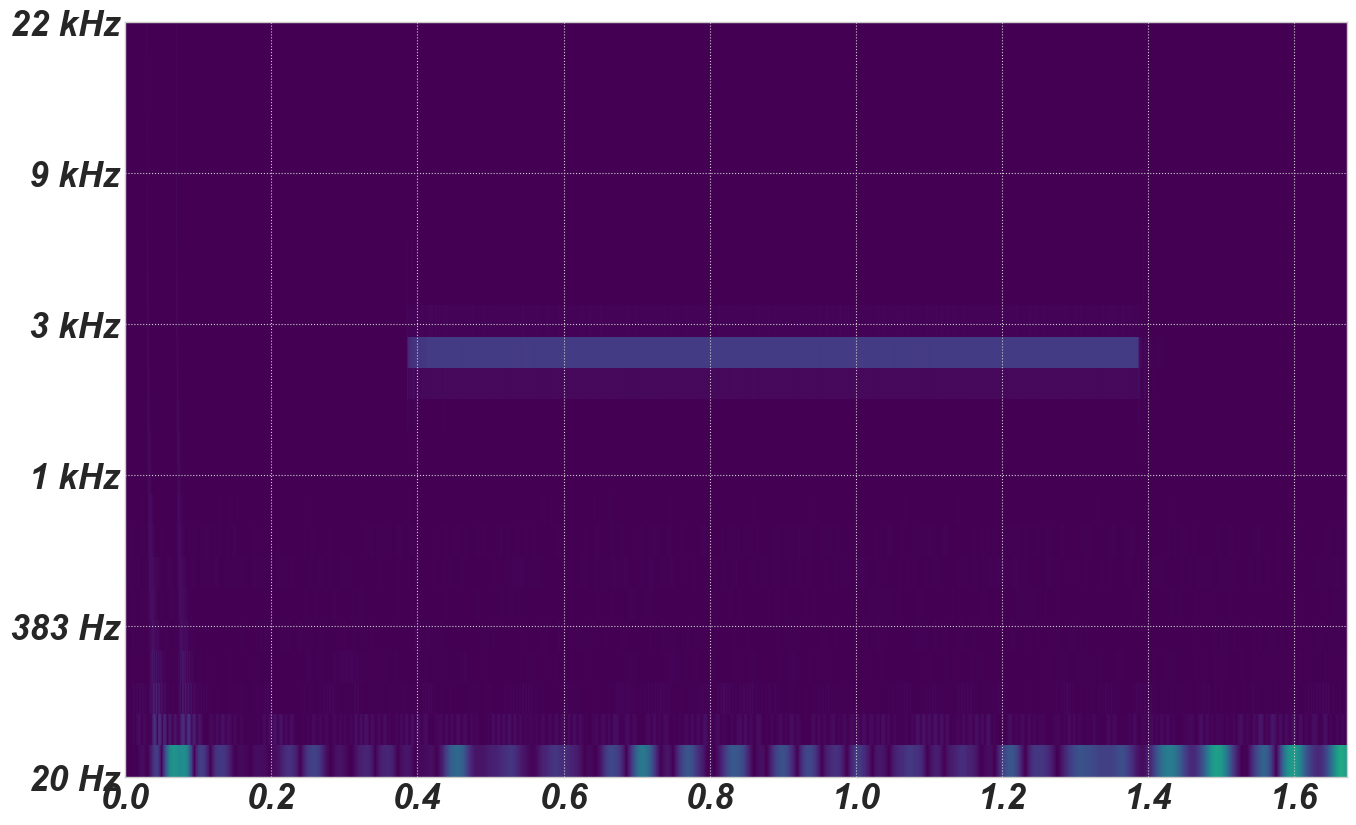

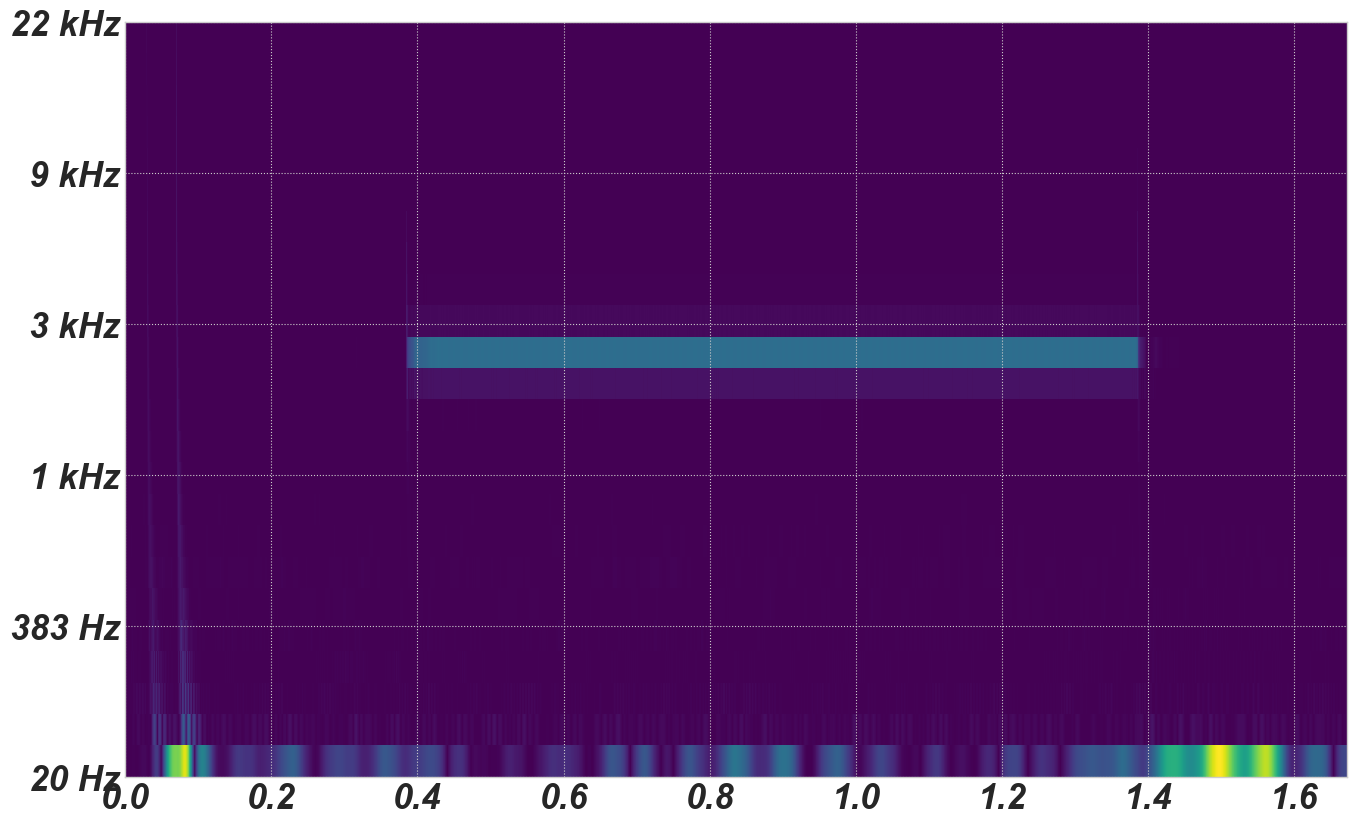

In [68]:
print(psd_l.shape)

from gammatone.filters import erb_point

fig = plt.figure()

ax = fig.add_subplot(111)
aspect_ratio = duration/scipy.constants.golden
img = ax.imshow(psd_l.T, extent=[0, duration , 1, 0], aspect=aspect_ratio,cmap='viridis',vmax = 1.0)

formatter = ERBFormatter(fmin, fs/2, unit='Hz', places=0)
ax.yaxis.set_major_formatter(formatter)


fig = plt.figure()

ax = fig.add_subplot(111)
aspect_ratio = duration/scipy.constants.golden
img = ax.imshow(psd_r.T, extent=[0, duration , 1, 0], aspect=aspect_ratio,cmap='viridis',vmax = 1.0)

formatter = ERBFormatter(fmin, fs/2, unit='Hz', places=0)
ax.yaxis.set_major_formatter(formatter)

In [69]:
############################################################
#                      Simulation                          #
############################################################

gammas_r = np.array([2.0])
kappas_r = np.array([3.0])
gammas_q = np.array([0.0])
kappas_q = np.array([0.0])


q_all = np.zeros((len(gammas_r),len(t),freq_bands))
r_all = np.zeros((len(gammas_r),len(t),freq_bands))

k =0
# do not use the indices
for ii,iii,iiii,iiiii in zip(gammas_r,kappas_r,gammas_q,kappas_q):
    
    for i in range(0, len(t)-1):
        for w in range(0,freq_bands):

            # E-E kernel
            ee_kernel = gauss(np.arange(0,freq_bands),w,1.0)
            ei_kernel = gauss(np.arange(0,freq_bands),w,1.2)
            ie_kernel = gauss(np.arange(0,freq_bands),w,1.0)
            ii_kernel = gauss(np.arange(0,freq_bands),w,1.0)

            # normalize it 
            ee_kernel /= np.max(ee_kernel)
            ei_kernel /= np.max(ie_kernel)
            ie_kernel /= np.max(ie_kernel)
            ii_kernel /= np.max(ie_kernel)


            delay_factor = 2
            # as an MNTB input we use the value of the previously calculated time step. 
            # By that we have a fix delay between the onset of the signal of direct SBC cells and the MNTB 
            if i < delay_factor:
                r_all[k,i+1,w] = r_all[k,i,w] +  dt * ode_r_bpc(r_all[k,i,w],s_sbc_all[i],ee_kernel,np.zeros(q_all.shape[2]),ei_kernel)       
            else:
                r_all[k,i+1,w] = r_all[k,i,w] +  dt * ode_r_bpc(r_all[k,i,w],s_sbc_all[i],ee_kernel,q_all[k,i-delay_factor,:],ei_kernel)       
            
            q_all[k,i+1,w] = q_all[k,i,w] +  dt * ode_q_pc(q_all[k,i,w],s_gbc_all[i],ie_kernel,q_all[k,i,:],ii_kernel)

    # increment index
    k+=1






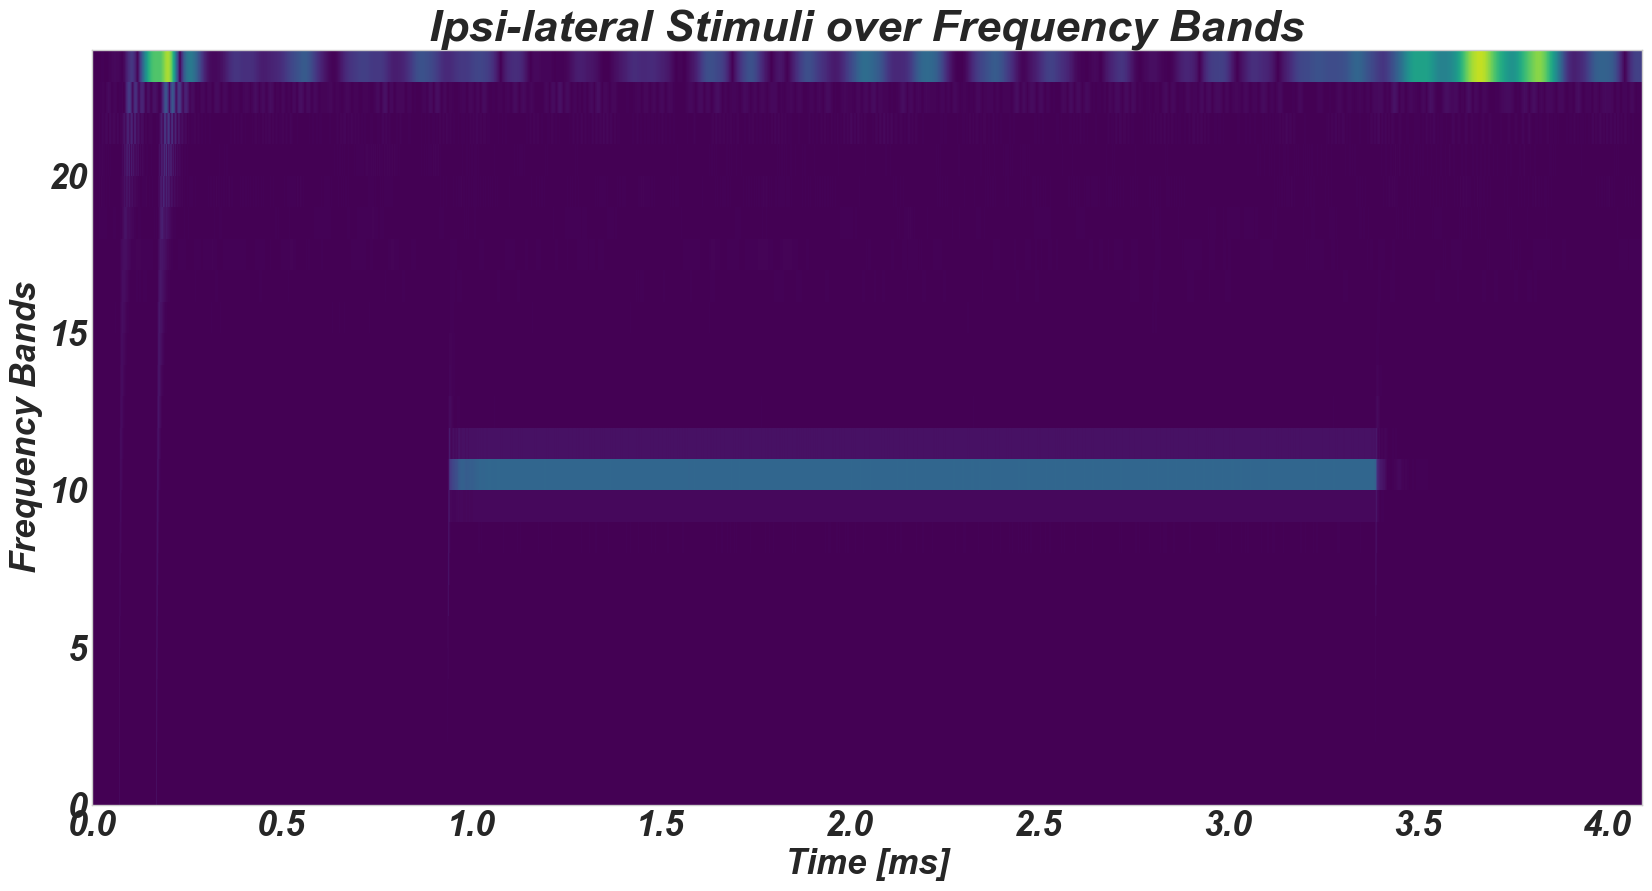

In [70]:
fig = plt.figure()
# ax = plt.pcolor(s_sbc_all[:,:].T,cmap='viridis',vmin=0., vmax=1.)
ax = fig.add_subplot(111)
ax.pcolormesh(s_sbc_all[:,:].T,cmap="viridis",linewidth=0,rasterized=True,vmin=0.,vmax=1.1)
plt.title('Ipsi-lateral Stimuli over Frequency Bands')
plt.xlabel('Time [ms]')
ax.set_xticklabels(ax.get_xticks()/1000)
plt.ylabel('Frequency Bands')

# plt.savefig(figure_name + 'ipsi_freq_bands.svg')
# plt.savefig(figure_name + 'ipsi_freq_bands.pdf')
plt.show()

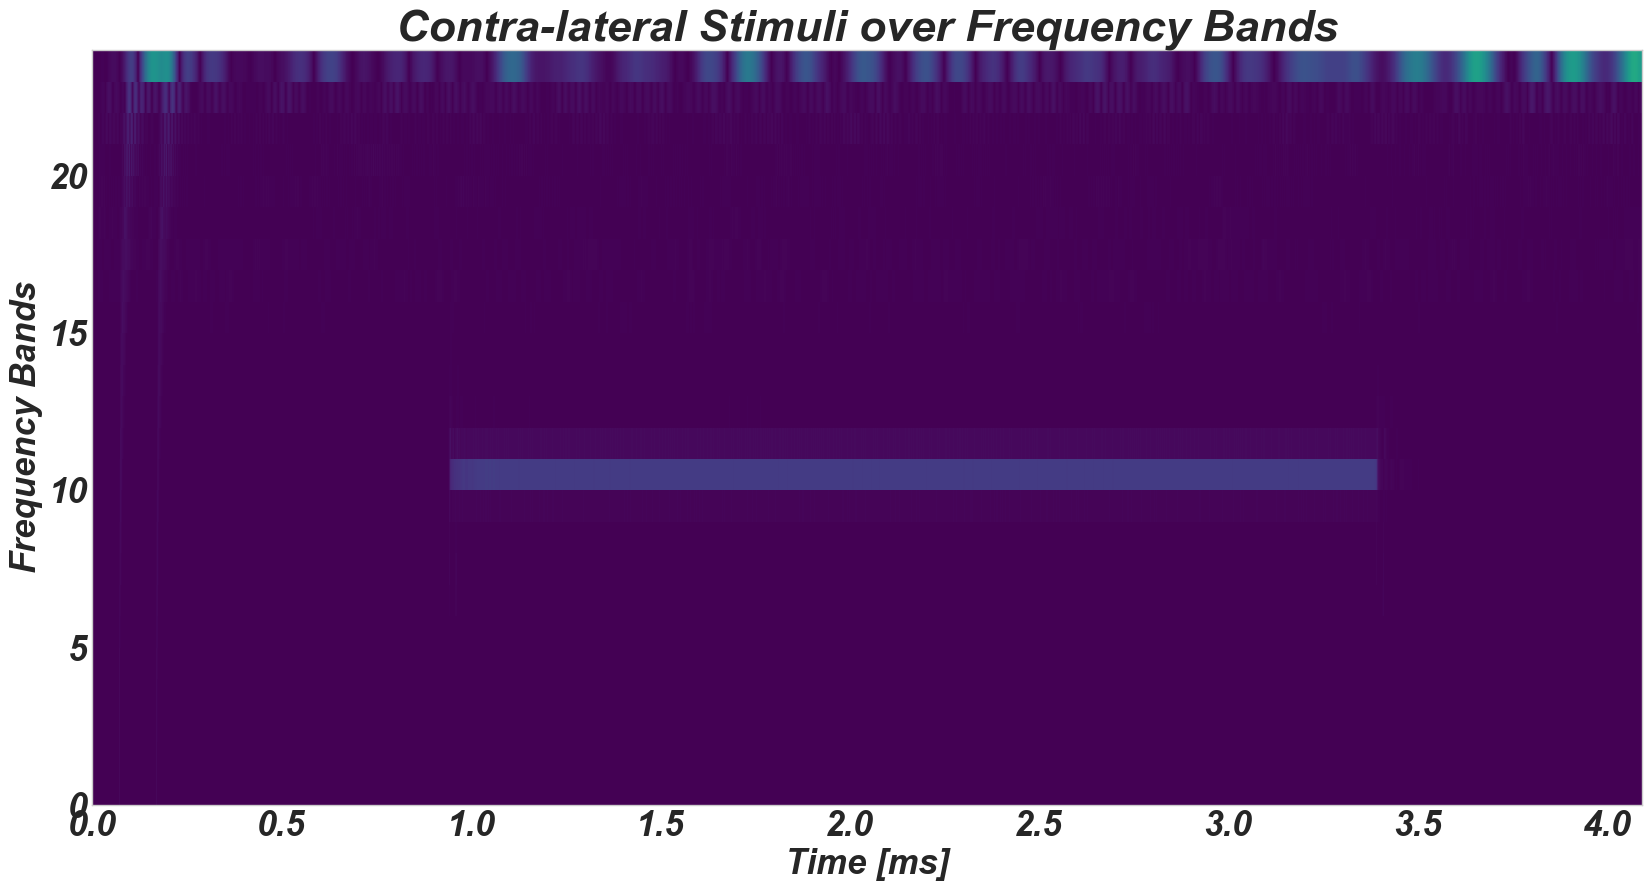

In [71]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.pcolormesh(s_gbc_all[:,:].T,cmap="viridis",linewidth=0,rasterized=True,vmin=0.,vmax=1.0)
plt.title('Contra-lateral Stimuli over Frequency Bands')
plt.xlabel('Time [ms]')
ax.set_xticklabels(ax.get_xticks()/1000)
plt.ylabel('Frequency Bands')

# plt.savefig(figure_name + 'contra_freq_bands.svg')
# plt.savefig(figure_name + 'contra_freq_bands.pdf')
plt.show()

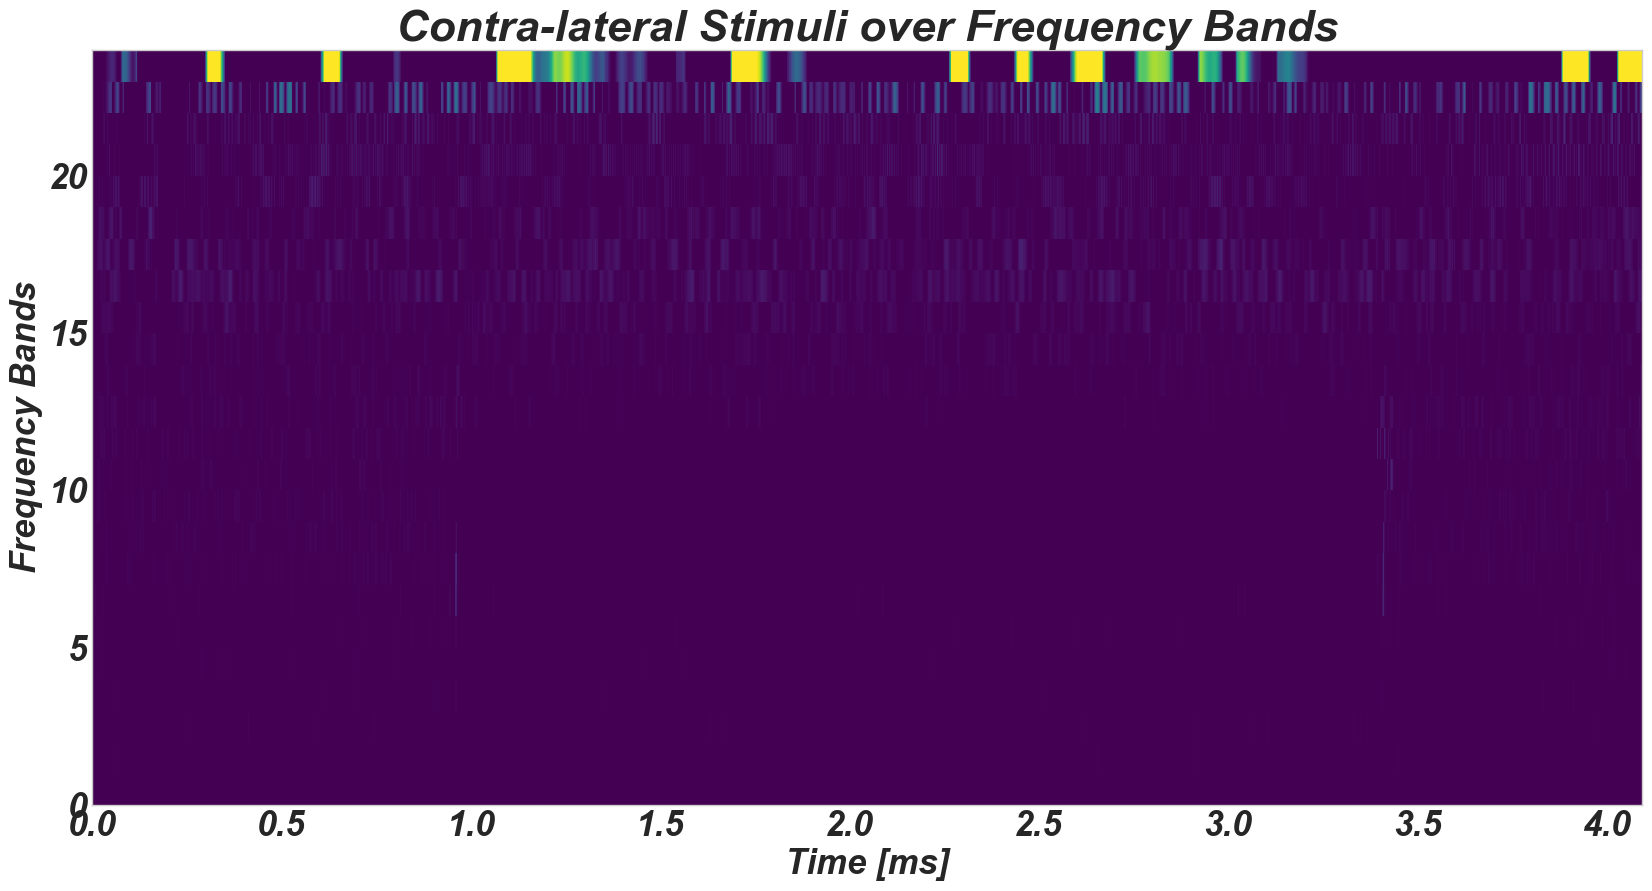

In [72]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.pcolormesh(s_gbc_all[:,:].T-s_sbc_all[:,:].T,cmap="viridis",linewidth=0,rasterized=True,vmin=0.,vmax=0.1)
plt.title('Contra-lateral Stimuli over Frequency Bands')
plt.xlabel('Time [ms]')
ax.set_xticklabels(ax.get_xticks()/1000)
plt.ylabel('Frequency Bands')

# plt.savefig(figure_name + 'contra_freq_bands.svg')
# plt.savefig(figure_name + 'contra_freq_bands.pdf')
plt.show()

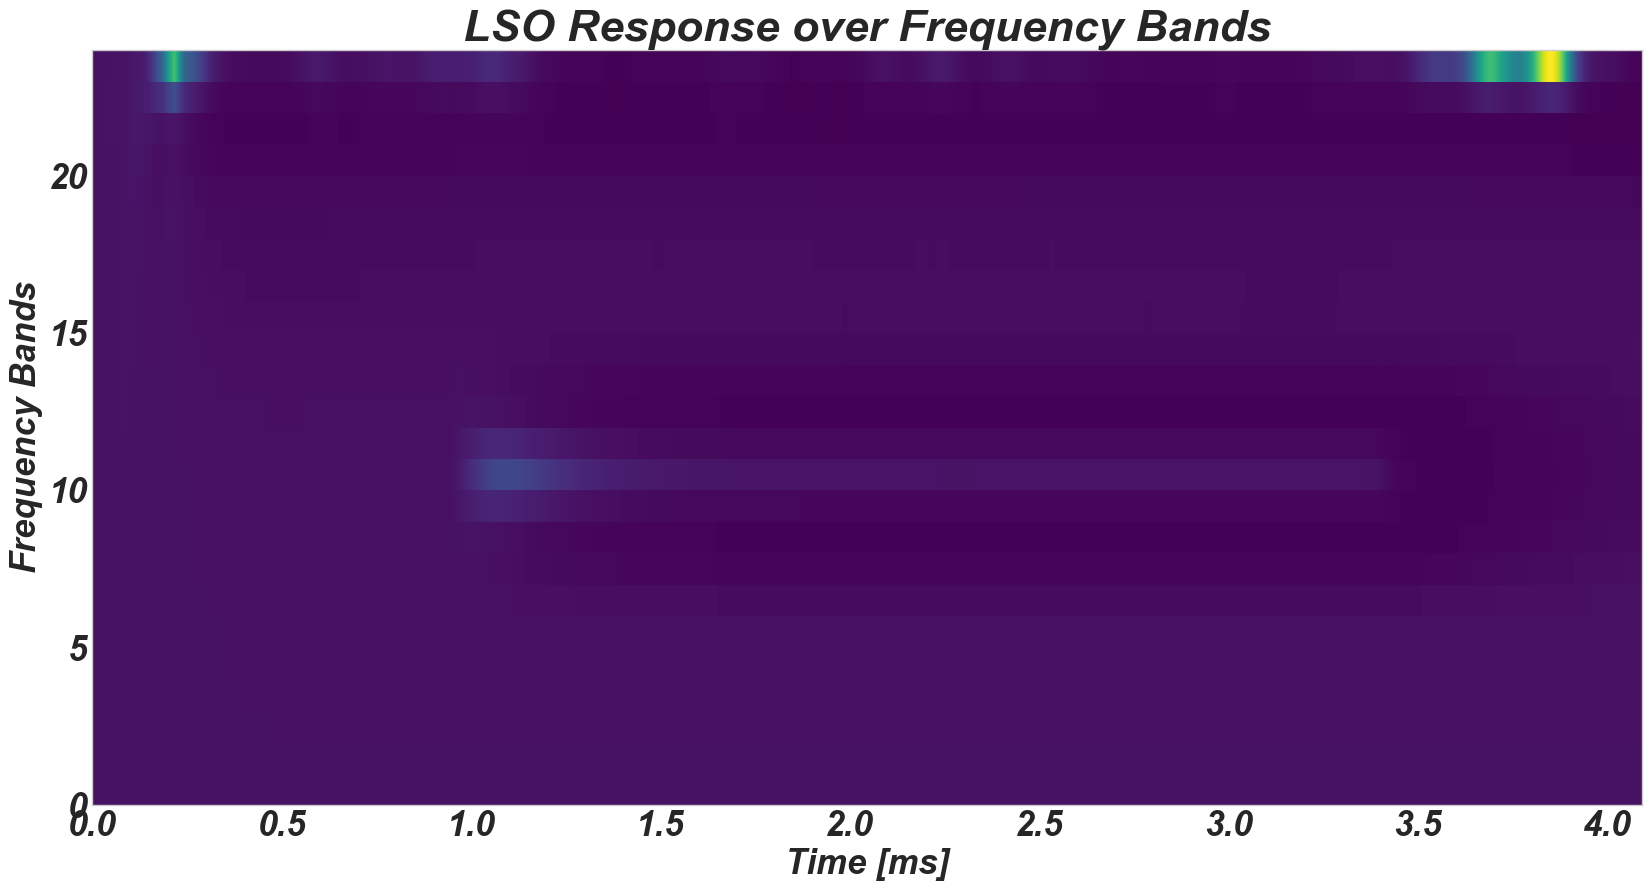

In [73]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.pcolormesh(g_r_out(r_all[0,:,:]).T,cmap="viridis",linewidth=0,rasterized=True)
plt.title('LSO Response over Frequency Bands')
plt.xlabel('Time [ms]')
ax.set_xticklabels(ax.get_xticks()/1000)
plt.ylabel('Frequency Bands')

# plt.savefig(figure_name + 'lso_freq_bands.svg')
# plt.savefig(figure_name + 'lso_freq_bands.pdf')

plt.show()

The reason why the MNTB needs a bigger IE kernel is that its inputs have usually a lower level. That is it either needs to be able to react to smaller changes in the input level or it receives input from a wider range of frequency bands.